# 様々な分類方法

## t-SNE の最適化まとめ

もう少し詳細な[解説](https://chatgpt.com/share/68c502de-cab8-800a-a0a0-9e4a7da834e9)

### 目的関数
高次元の類似度分布 \(P=\{p_{ij}\}\) と、低次元での類似度分布 \(Q=\{q_{ij}\}\) を一致させるために  
KLダイバージェンスを最小化する：

$$
C = KL(P \parallel Q) = \sum_{i \ne j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

- \(p_{ij}\)：高次元での「近さ」  
- \(q_{ij}\)：低次元での「近さ」  
- **局所構造を強調**するため、向き付き KL を採用  

---

### 低次元側の分布 \(Q\)
コーシー分布（自由度1のt分布）を使用：

$$
q_{ij} = \frac{(1+\lVert y_i-y_j\rVert^2)^{-1}}
{\sum_{k\ne l}(1+\lVert y_k-y_l\rVert^2)^{-1}}, 
\quad q_{ii}=0
$$

- **厚い尾 (heavy-tailed)** により遠距離の斥力が残り、  
  **過密化 (crowding problem)** を防ぐ  

---

### 勾配（更新式）

$$
\frac{\partial C}{\partial y_i}
= 4 \sum_{j \ne i} (p_{ij} - q_{ij}) 
\frac{(y_i - y_j)}{1 + \lVert y_i-y_j\rVert^2}
$$

- \(p_{ij} > q_{ij}\) → 引力（近づける）  
- \(p_{ij} < q_{ij}\) → 斥力（離す）  
- 分母により **近距離は強く、遠距離は緩やか**  

---

### 実務での工夫
- **Perplexity**: 近傍の有効サイズ (5〜50程度)  
- **Learning rate**: 大きすぎると発散、小さすぎると停滞 (200〜1000が目安)  
- **Early exaggeration**: 学習初期に \(P\) を強調 → クラスタを固めてから斥力で広げる  
- **初期化**: PCA 初期化が安定、ランダムは絵が変わる  

---

### 直感まとめ
- **KL最小化** → 本当に近い点は必ず近所に  
- **コーシー分布** → クラスタを分離しやすい  
- **勾配の形** → 引力と斥力のバランスで「いい絵」が出る


### 以下の手書きデータについてPCA（主成分分析）とt-SNE（多様体学習アルゴリズム）で比較してみる

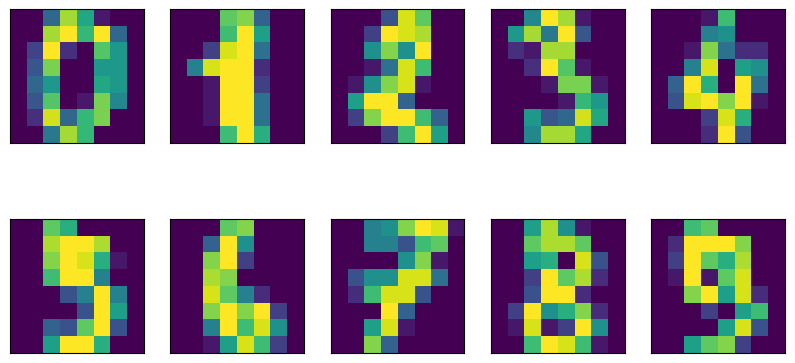

In [2]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={"xticks": [], "yticks": []})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

#### PCA

Text(0, 0.5, 'Second principal component')

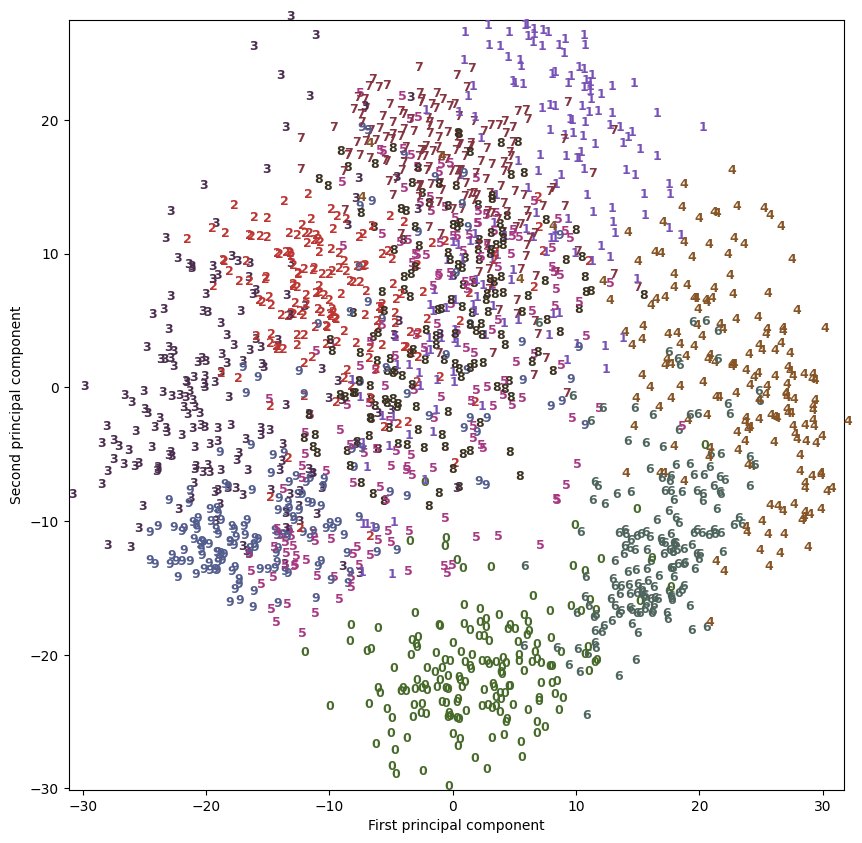

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(digits.data)
digits_pca = pca.transform(digits.data)
colors = [
    "#476A2A",
    "#7851B8",
    "#BD3430",
    "#4A2D4E",
    "#875525",
    "#A83683",
    "#4E655E",
    "#853541",
    "#3A3120",
    "#535D8E",
]

plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
    plt.text(
        digits_pca[i, 0],
        digits_pca[i, 1],
        str(digits.target[i]),
        color=colors[digits.target[i]],
        fontdict={"weight": "bold", "size": 9},
    )
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

#### t-SNE

Text(0, 0.5, 't-SNE feature 1')

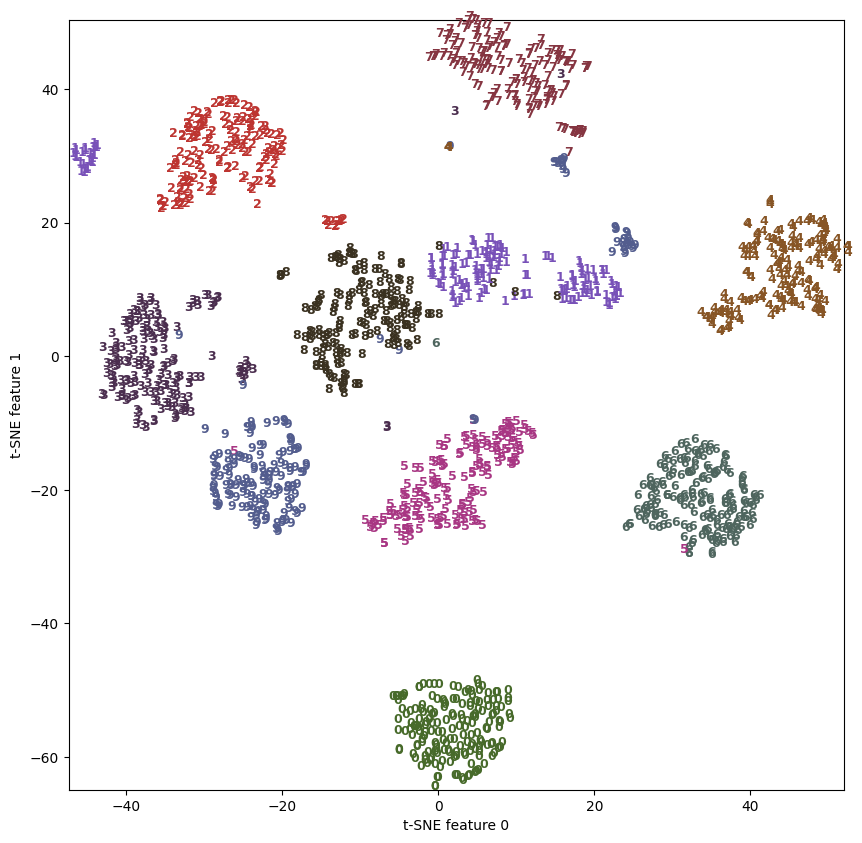

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max())
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max())
for i in range(len(digits.data)):
    plt.text(
        digits_tsne[i, 0],
        digits_tsne[i, 1],
        str(digits.target[i]),
        color=colors[digits.target[i]],
        fontdict={"weight": "bold", "size": 9},
    )
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

↑かなりうまく分類されてる。教師なし学習なのに特徴を2次元まで落としたうえでこれほど捉えられるのは凄い。

## k-meansクラスタリング

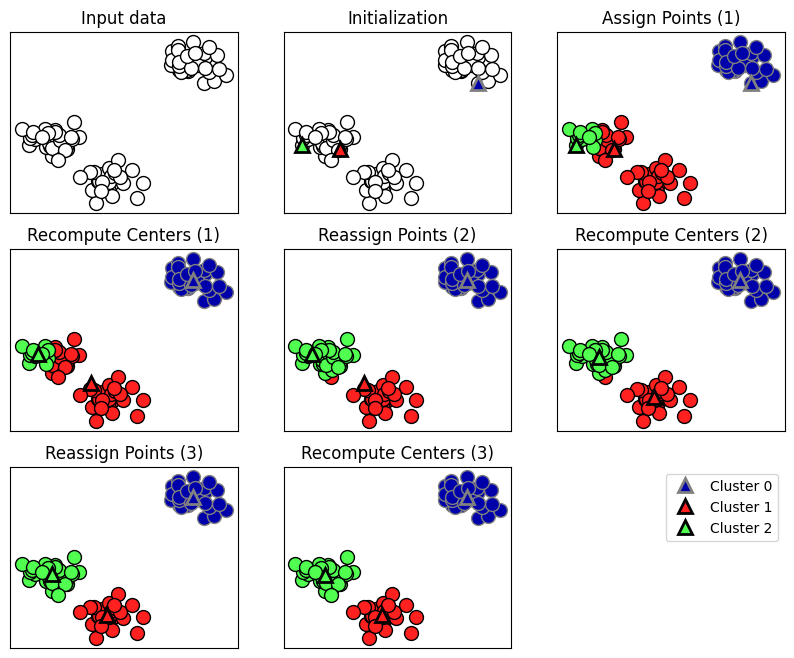

In [ ]:
import mglearn

mglearn.plots.plot_kmeans_algorithm()

↑アルゴリズムとしてはこんな感じで、各クラスタの重心を探して変化しなくなったら終了。

#### ↓クラスタ境界

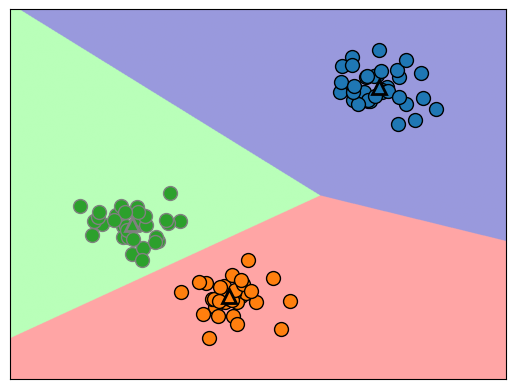

In [6]:
mglearn.plots.plot_kmeans_boundaries()

## 凝集型クラスタリング

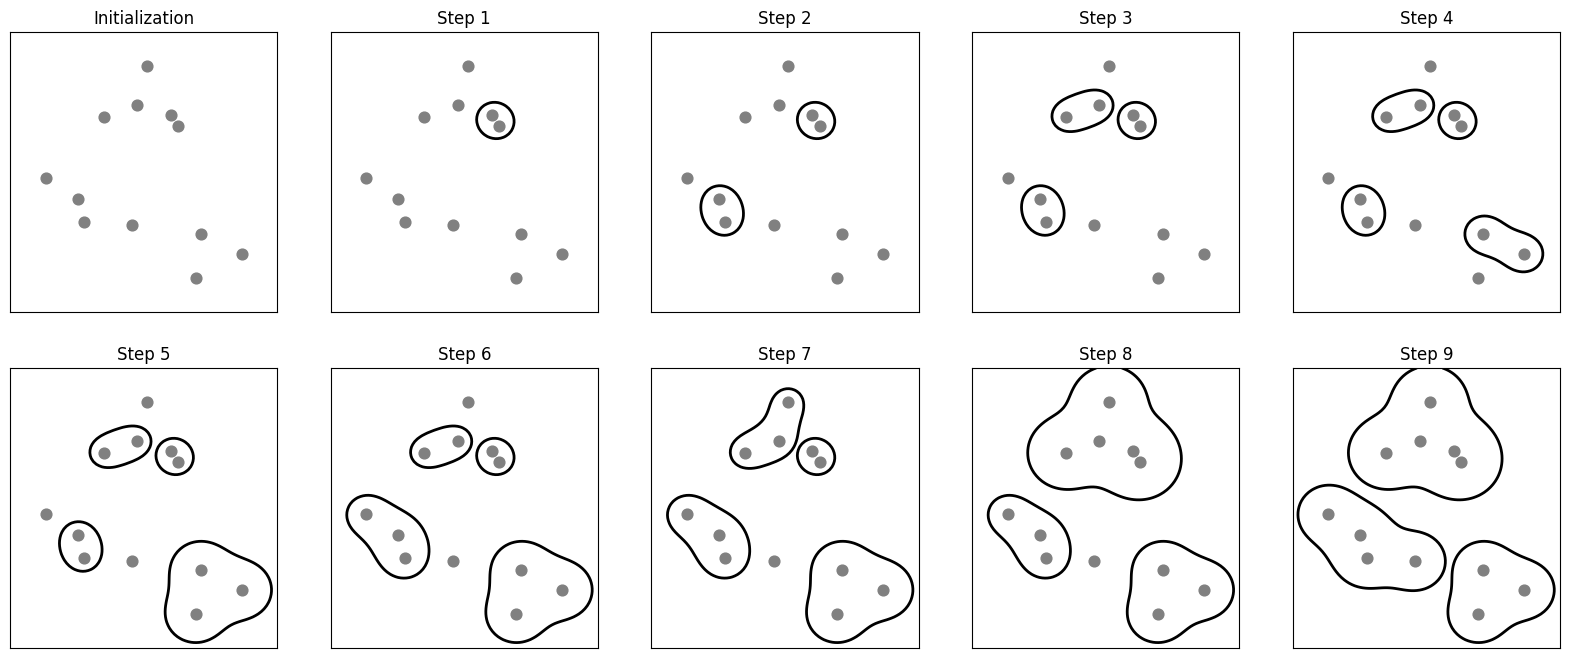

In [7]:
mglearn.plots.plot_agglomerative_algorithm()

### sklearnでの実装

Text(0, 0.5, 'Feature 1')

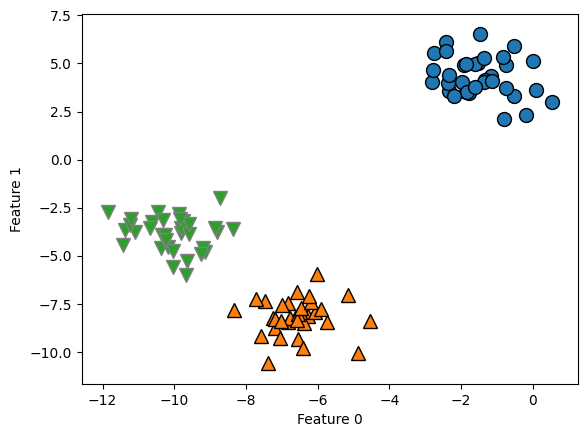

In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering

X, y = make_blobs(random_state=1)
agg = AgglomerativeClustering(n_clusters=3)
assinment = agg.fit_predict(X)

mglearn.discrete_scatter(X[:, 0], X[:, 1], assinment)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

現実問題ではクラスタ数自体がわからない場合が想定される。

### 階層型クラスタリングとデンドログラム

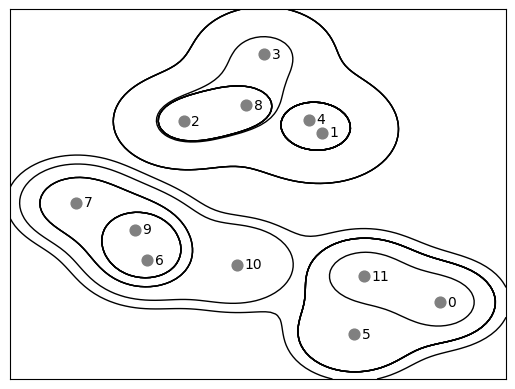

In [12]:
mglearn.plots.plot_agglomerative()

## クラスタリングにおけるブリッジ距離（Bridge Distance）のメモ

### 定義
クラスタリングでは、クラスタ間の「距離」を定義する方法が複数あります。  
その中で **ブリッジ距離** は、2つのクラスタをつなぐ **最も近い点同士の距離** を指します。  
これは **シングルリンク法（single-linkage clustering）** と同じ考え方です。

---

### 数式による定義
クラスタ \( C_i \), \( C_j \) のブリッジ距離 \( d(C_i, C_j) \) は次のように表されます：

$$
d(C_i, C_j) = \min_{x \in C_i,\, y \in C_j} \; \lVert x - y \rVert
$$

ここで、  
- \( x \in C_i \): クラスタ \( C_i \) に属するデータ点  
- \( y \in C_j \): クラスタ \( C_j \) に属するデータ点  
- \( \lVert x - y \rVert \): ユークリッド距離（または他の距離尺度）

---

### 特徴
- **利点**
  - 細長いクラスタや非凸形状でも結合できる。
  - データが「鎖状」に連なる場合でもクラスタを適切につなげる。

- **欠点**
  - 外れ値（ノイズ）に敏感。
  - 「チェイニング現象」が起こりやすく、本来は独立したクラスタが細い点列で結合してしまうことがある。

---

### 他のクラスタ間距離との比較
- **ブリッジ距離（シングルリンク法）**  
  → 最も近い点同士の距離を採用  

- **コンプリートリンク法**  
  → 最も遠い点同士の距離を採用  

- **群平均法（average-linkage）**  
  → クラスタ間のすべての点の平均距離を採用  

---

### 直感的なイメージ
例えば2つのクラスタが「U字型」に配置されている場合：  
- **重心距離** では遠くに見える  
- **ブリッジ距離** では U の端点同士が近いため「つながっている」と判定されやすい

### ユークリッド距離との違い
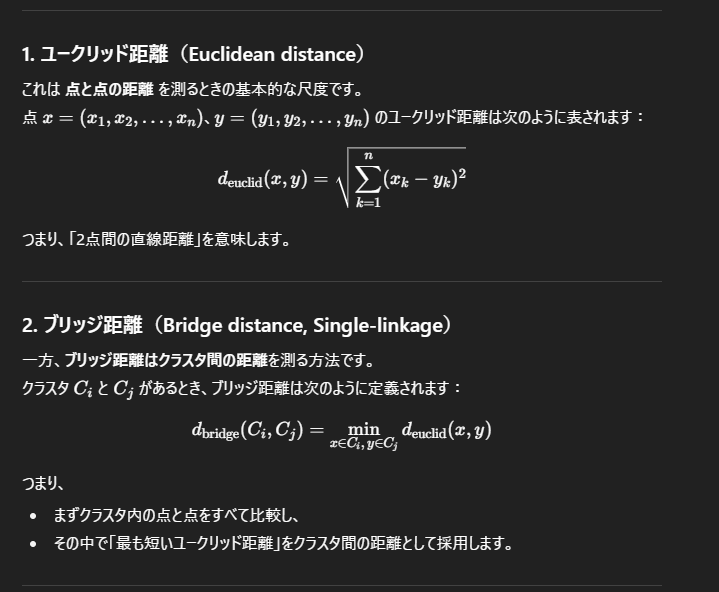


### デンドログラムの描画

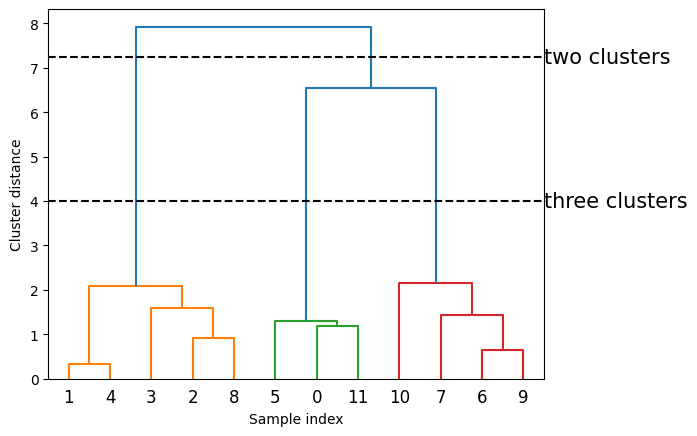

In [13]:
from scipy.cluster.hierarchy import dendrogram, ward

X, y = make_blobs(random_state=0, n_samples=12)

# ブリッジ距離の配列を返す
linkage_array = ward(X)
# デンドログラムのプロット
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], "--", color="k")
ax.plot(bounds, [4, 4], "--", color="k")

ax.text(bounds[1], 7.25, "two clusters", va="center", fontdict={"size": 15})
ax.text(bounds[1], 4, "three clusters", va="center", fontdict={"size": 15})
ax.set_xlabel("Sample index")
ax.set_ylabel("Cluster distance")
plt.show()

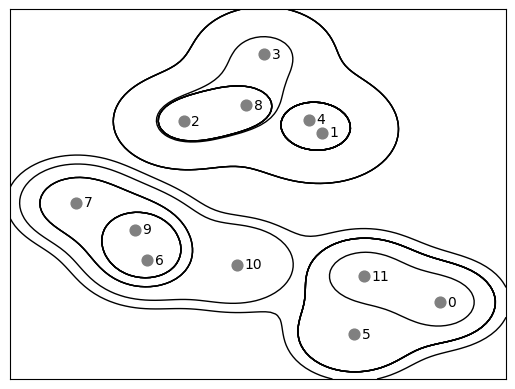

In [14]:
mglearn.plots.plot_agglomerative()

# DBSCAN（Density-Based Spatial Clustering of Applications with Noise）

DBSCAN は、密度に基づくクラスタリング手法の代表例です。  
K-means のようにクラスタ数を事前に指定する必要がなく、  
「高密度な領域をクラスタ」「疎な領域はノイズ（外れ値）」とみなして自動的にクラスタを形成します。  

---

## 基本アイデア
- データ空間において **「一定の半径内に十分な点が存在するか」** でクラスタを判定します。
- パラメータは主に2つ：
  - **ε（eps）**：半径の大きさ  
  - **MinPts**：その半径内に必要な最小点数  

---

## 点の分類
DBSCAN では各データ点を次の3種類に分類します：

1. **コア点（Core Point）**  
   半径 ε の範囲に **MinPts 以上** の点がある点。クラスタの「中心」となる。  

2. **境界点（Border Point）**  
   半径 ε 内に MinPts 未満の点しかないが、**あるコア点の近傍に含まれる**点。  

3. **ノイズ点（Noise Point, Outlier）**  
   どのコア点の近傍にも属さない孤立した点。  

---

## アルゴリズムの流れ
1. すべての点を「未訪問」とする。  
2. 未訪問点を選び、半径 ε 内の点を探索。  
3. もし MinPts 以上ならその点はコア点 → クラスタを新規生成し、近傍点を再帰的に追加。  
4. MinPts 未満なら一旦ノイズ扱い。ただし後で他のクラスタの境界点になる可能性もある。  
5. 全点を訪問するまで繰り返す。  

---

## 数式的定義
- **ε-近傍**  

$$
N_{\varepsilon}(p) = \{ q \in D \mid \text{dist}(p, q) \leq \varepsilon \}
$$

- **コア点条件**  

$$
|N_{\varepsilon}(p)| \geq \text{MinPts}
$$

ここで、$\text{dist}$ は通常ユークリッド距離を用います。  

---

## DBSCANの特徴

### メリット
- クラスタ数を事前に指定しなくてよい。  
- 任意の形状のクラスタを見つけられる（K-means は球状に近いクラスタしか得られない）。  
- 外れ値（ノイズ）を自動で識別できる。  

### デメリット
- パラメータ **ε** と **MinPts** の選び方が結果に大きく影響。  
- 高次元空間では密度が均一化してしまい、うまく動作しないことがある。  

---

## 直感的イメージ
- ε を「近さのしきい値」、MinPts を「仲間の最低人数」と考えるとわかりやすい。  
- 「一定距離内に友達が十分にいる人（コア点）」が集まってコミュニティ（クラスタ）を作り、  
  周辺にいる「友達が少ないけどコミュニティの近くにいる人（境界点）」も仲間に入り、  
  どこにも属せない「ぼっち（ノイズ点）」は排除される。  


### 様々なeps,min_sampleで試してみる

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


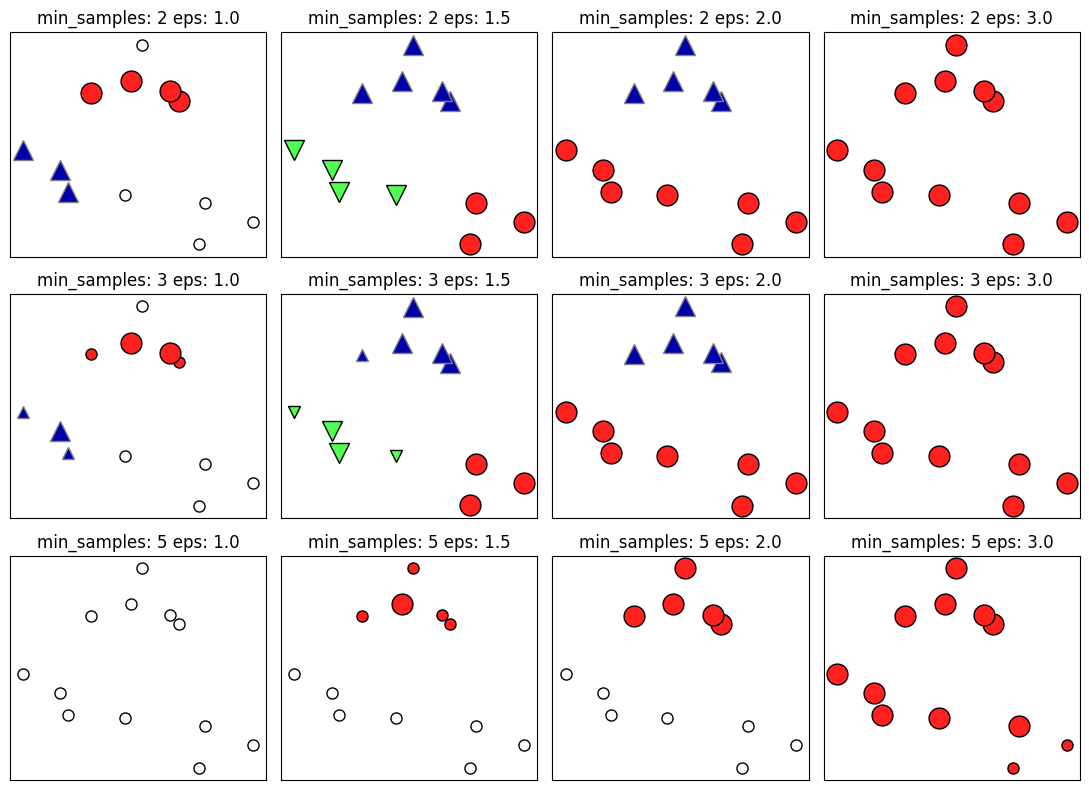

In [15]:
mglearn.plots.plot_dbscan()

### two_moonsデータセットを標準偏差でスケール変換してDBSCANを適用してみる

Text(0, 0.5, 'Feature 1')

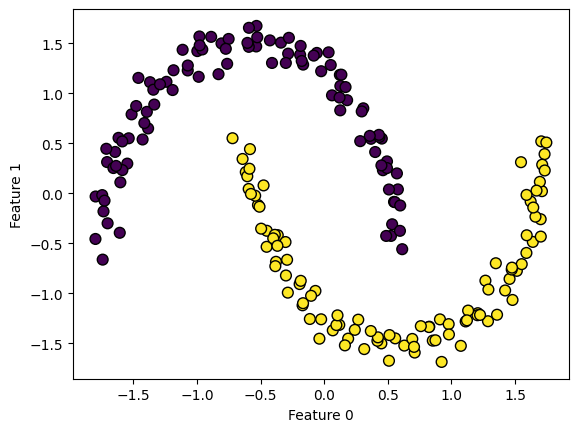

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN()
cluster = dbscan.fit(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster.labels_, s=60, edgecolors="k")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")